In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
# Size scaling, figsize is given in inches so we need to scale it to the width we require for our paper
# An A4 papers dimensions are 21cm x 29.7cm so:
cm =  1/2.54 
margin = 2.5*cm
pt_inch = 1/72.27
column_sep = 20*pt_inch
twocolumn_width = (21*cm - 2*margin)*3
column_width = (21*cm - 2*margin - column_sep)


# Turns out scaling doesnt work the way I hoped it woudl so we will jsut use double values as scaling is required anyway
# So using the numbers above while trying to get the resulting text to be 10pt is not possible, could make the graphs bigger but this way text is approx 8-9 pt so good enough


# For two column plots then we use twocolumn_width and for one column use column_width

# Set default plt params
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('font', serif="Times New Roman")
plt.rc('figure', titlesize=14) # TODO: Change axis label size to something larger then decrease tick size and see if it fits that way


## Populate transport params and AMS data

In [4]:
# Set model dir:

model_dir = '/home/felix/USINE_docker/SLIM_data_pres'
data_dir = '/home/felix/USINE_docker/data/USINE_FILES'


latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}

# Read out file
transport_params = {}
with open(model_dir+'/model_vals_pars.out', 'r') as f:
    lines = f.readlines()
    cond = False
for line in lines:
    if '# Source' in line:
        cond = False
        break 
    if cond and line!='\n':
        key, value = line.split('=')
        # Latex format key
        key = latex_format[key.strip(' ')]
        # Add units
        key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
        if key.strip(' ') not in transport_params.keys():   
            transport_params[key.strip(' ')] = float(value.split('[')[0].strip(' '))
    if '# Transport' in line:
        cond = True
# Read .C files for Double ts to retrieve data for isotopes etc. 
C_dat = {}
for i in os.listdir(model_dir):
    if i.endswith('.C'):
        with open(os.path.join(model_dir, i), 'r') as f:
            lines = f.readlines()
        cond = False
        for line in lines:
            # If stop not found
            if cond:
                if '}' not in line:
                    content.append(float(line.strip('\n').strip(',').strip(';').strip('')))
                else:
                    content.append(float(line.strip('\n').strip(',').strip(';').strip('')[:-1:]))
            # Recognize start
            if 'Double_t' in line:
                name = line[12::].split('[')[0] # Gives data descriptor
                content = []
                cond = True
            # Find stop
            if "}" in line and cond:
                cond = False
                C_dat[name] = content


AMS_data = {} # TODO: Load and format ams data for plotting

for i in os.listdir(data_dir):
    if 'orig' not in i and 'cov' not in i and 'prelim' not in i and "DAMPE" not in i and 'CALET' not in i and 'BC_AMS02.USINE' not in i and '.DS' not in i:
        with open(os.path.join(data_dir, i), 'r') as f:
            try:
                lines = f.readlines()
                # Debugging copy
                lines_cp = lines
            except:
                print(os.path.join(data_dir, i))
                pass
        commented_lines = len([i for i in lines if '#' in i])
        lines = [i for i in lines if '#   Col.' in i]
        headers = [i.split('-')[1].strip('\n').strip(' ') for i in lines]
        # FSi O and some more dont have headers, the assumption is they all have the same headers
        if len(headers)<2: 
            print(i.split('_')[0], ' doesnt have headers')
            headers = headers_backup
        else:
            headers_backup = headers
        try:
            #if i.split('_')[0]=='O': print(pd.read_csv(os.path.join(data_dir, i), names=headers, skiprows=commented_lines,encoding='us-ascii', delimiter=r"\s+"))
            AMS_data[i.split('_')[0]]=pd.read_csv(os.path.join(data_dir, i), names=headers, skiprows=commented_lines,encoding='us-ascii', delimiter=r"\s+")
        except Exception as e:
            print(e)
            print(os.path.join(data_dir, i))

FSi  doesnt have headers
FSIREF.dat  doesnt have headers


## Plotting

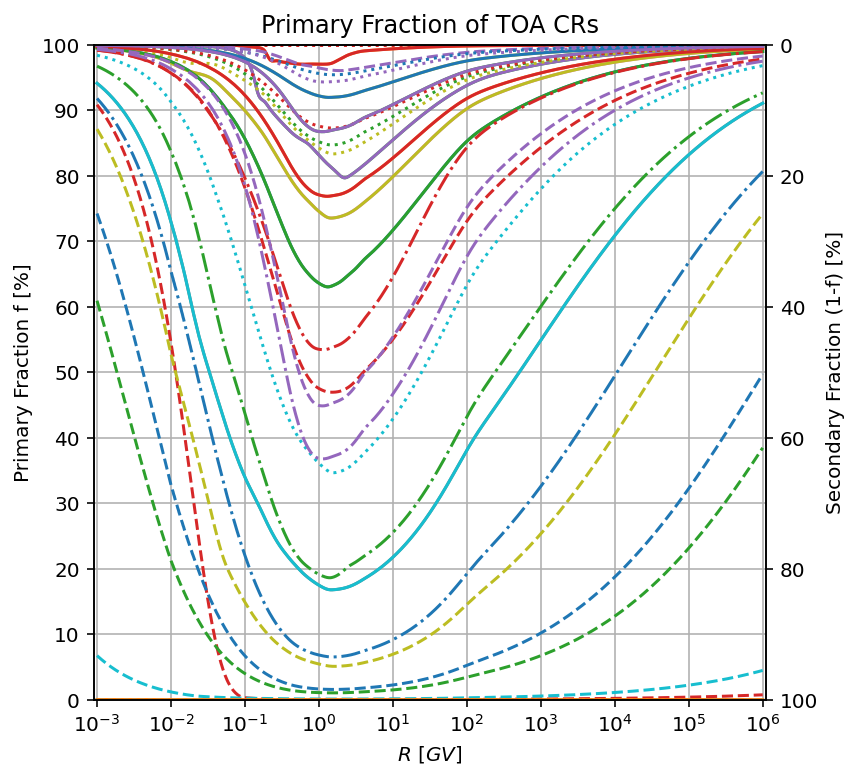

In [12]:
latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}


#       Boilerplate
fig,ax = plt.subplots(figsize=(column_width,column_width))
fig.set_dpi(72*2)

plt.title('Primary Fraction of TOA CRs')

plt.xlim(0.0009,1100000)
plt.ylim(0,100)
plt.xscale('log')

plt.grid()
plt.xlabel('$R\ [GV]$')
plt.ylabel('Primary Fraction f [%]')

# Second y axis
ax_twin = ax.twinx()
ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
ax_twin.set_ylim(100,0)

# ticks
ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())



# Get colors and marker formatters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

while len(colors)<26:
    colors += colors

# Linestyles
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.'
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]



#       Plotting
counter=0 #Keeps track of Z

for key in C_dat:
    if 'primaryfrac' in key:
        if 'fy' not in key:
            label = key.split('_')[1]

            if not label[0].isnumeric():
                isotope_counter = 0
                counter+=1
                linestyle = 'solid'
            else:
                isotope_counter += 1
                linestyle = linestyle_str[isotope_counter][1]

            ax.plot(C_dat[key], C_dat[key.replace('fx','fy')],c=colors[counter],linestyle= linestyle, label=label)


#ax.legend()

#plt.savefig('/home/felix/USINE_data/gen_graphics/{}_primary_fraction.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')

plt.show()

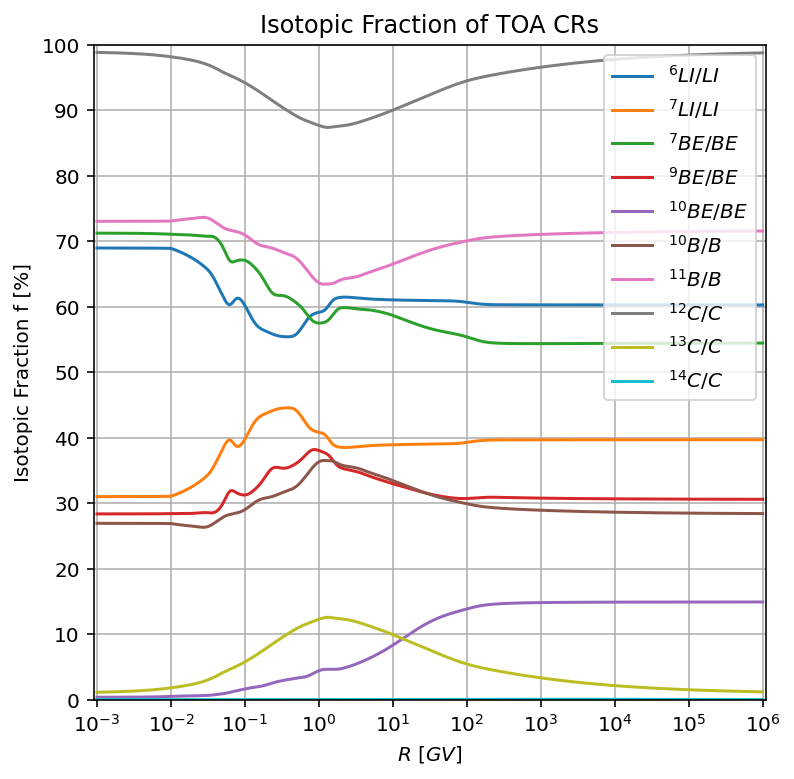

In [13]:
# isotopic fraction plot


elements_to_plot = ['LI','BE','B','C']


#       Boilerplate
fig,ax = plt.subplots(figsize=(column_width,column_width))
fig.set_dpi(72*2)

plt.xlim(0.0009,1100000)
plt.ylim(0,100)
plt.xscale('log')

plt.title('Isotopic Fraction of TOA CRs')

plt.grid()
plt.xlabel('$R\ [GV]$')
plt.ylabel('Isotopic Fraction f [%]')

# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


#       Plotting
for key in C_dat:
    if 'isotopicfrac' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            if any([label[-len(i):]==i and label[-len(i)-1].isnumeric() for i in elements_to_plot]):

                if label[1].isnumeric():
                    label = '$^{'+label[0:2]+'}'+label[2:]+'/'+label[2:]+'$'
                else:
                    label = '$^{'+label[0]+'}'+label[1:]+'/'+label[1:]+'$'

                ax.plot(C_dat[key], C_dat[key.replace('fx','fy')], label=label)

ax.legend()

#plt.savefig('/home/felix/USINE/gen_graphics/{}_isotopic_fraction.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')

plt.show()

## B, C and B/C plots

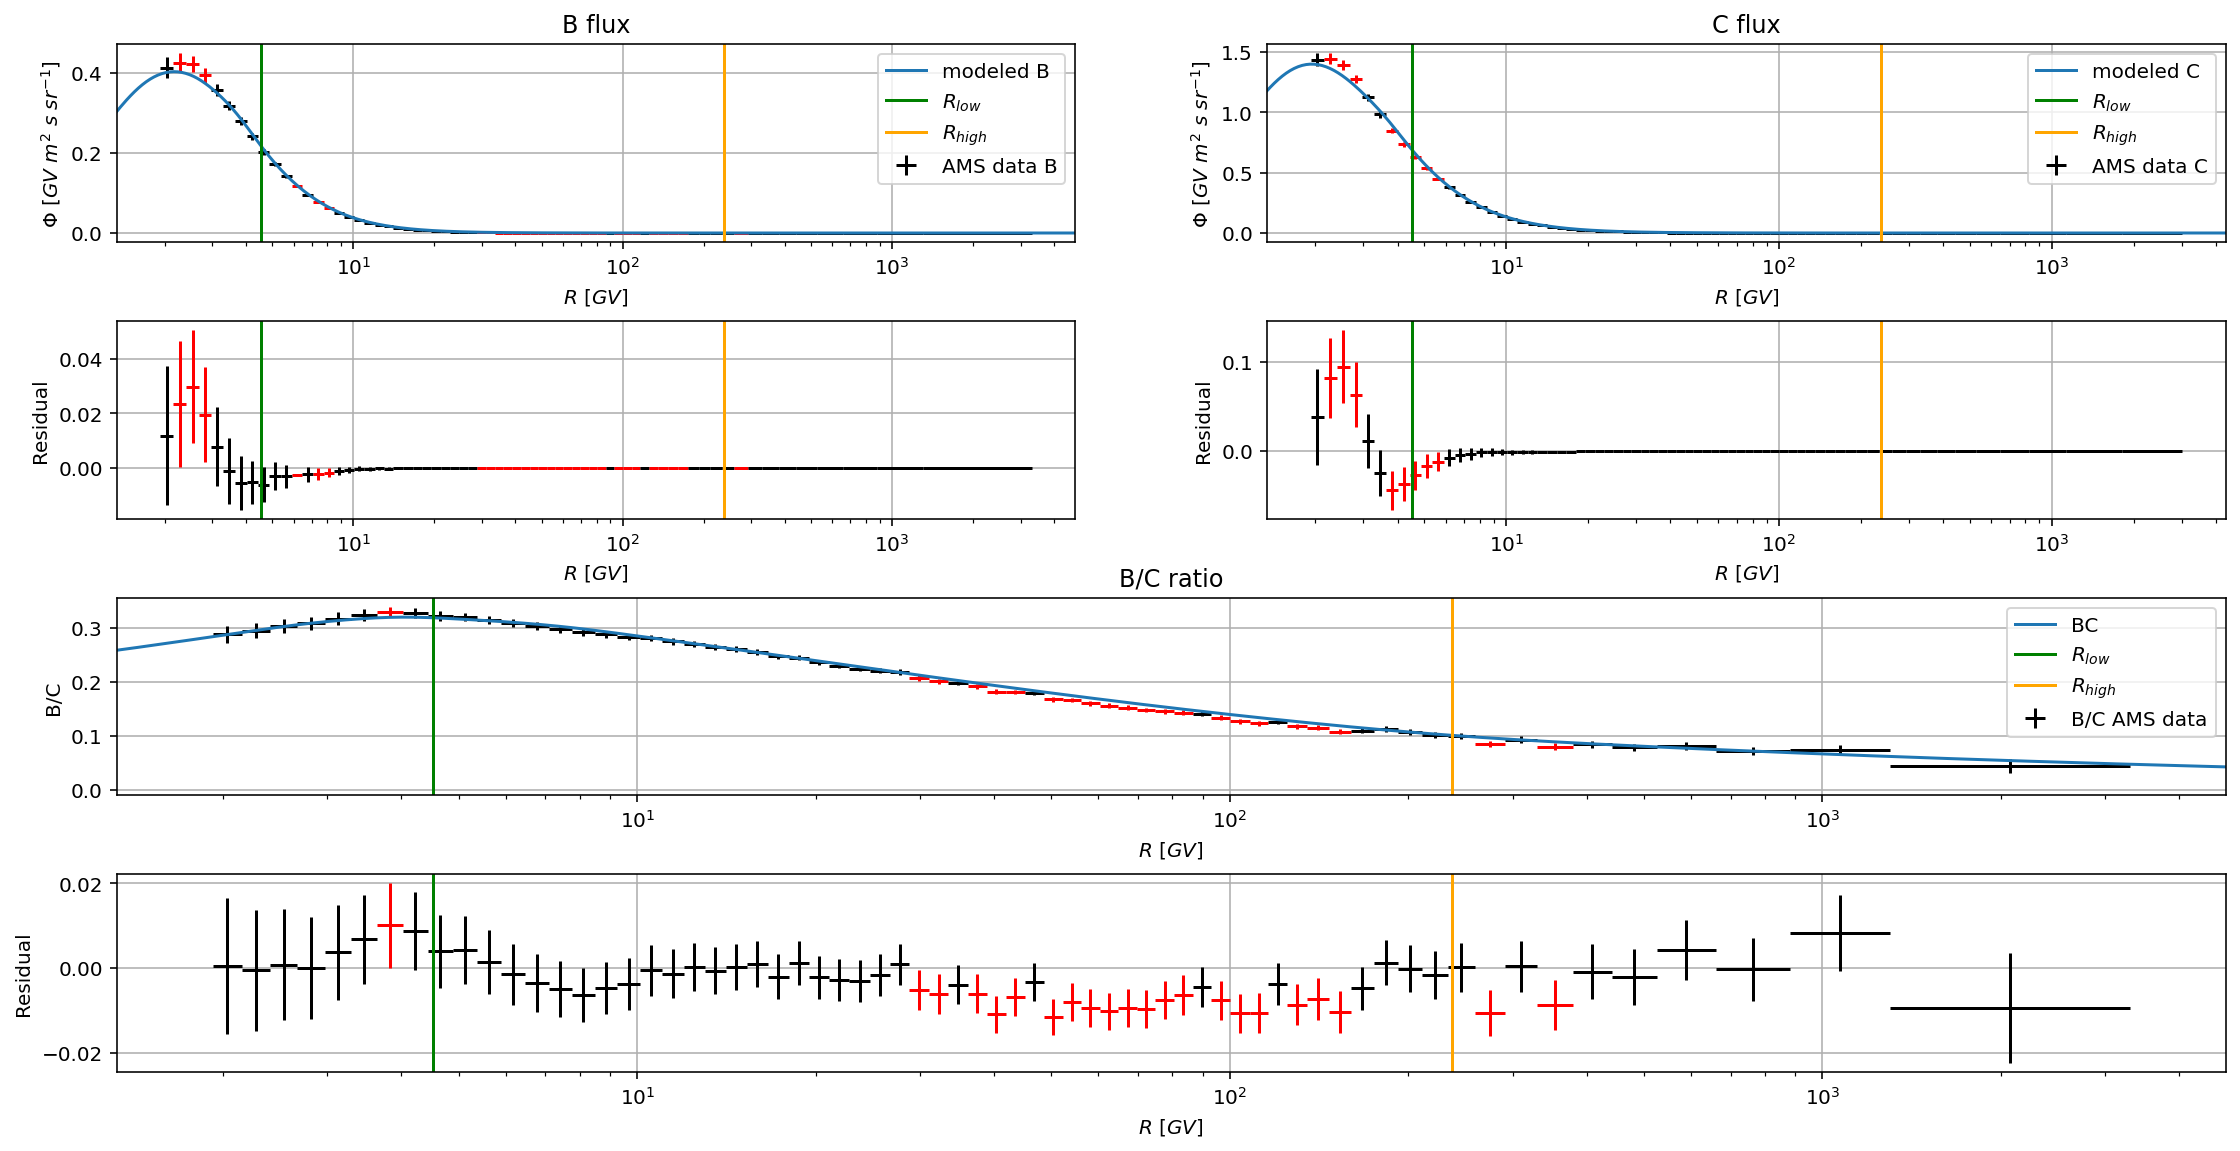

In [14]:
# B, C, B/C plots

#       Boilerplate
fig = plt.figure(figsize=(twocolumn_width,0.5*twocolumn_width))
#plt.xlim(0.0009,1100000)
#plt.ylim(0,100)
fig.set_dpi(72*2)



# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
#ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
#ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.subplots_adjust(hspace=0.4)

#       Plotting
ax1 = fig.add_subplot(4,2,1)
ax1_r = fig.add_subplot(4,2,3)
ax2 = fig.add_subplot(4,2,2)
ax2_r = fig.add_subplot(4,2,4)
ax3 = fig.add_subplot(4,2,(5,6))
ax3_r = fig.add_subplot(4,2,(7,8))
for i in (ax1, ax2, ax3):
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

for i in (ax1_r, ax2_r, ax3_r):
    i.set_xscale('log')
    i.set_ylabel('Residual')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

for i in (ax1, ax2):
    i.set_ylabel('$\Phi\ [GV\ m^2\ s\ sr^{-1}]$')

ax3.set_ylabel('B/C')

for key in C_dat:
    if 'model_' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            if label == 'B':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])
                # Get coloring scheme
                colors = [data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit-(data['ERR_STAT']+data['ERR_SYST']), data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit+(data['ERR_STAT+']+data['ERR_SYST+'])]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax1.plot(C_dat[key], C_dat[key.replace('fx','fy')], label='modeled '+label)
                ax1.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'], x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
                ax1.set_title('B flux')
                # Plot residuals
                ax1_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)

            if label == 'C':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])
                # Get coloring scheme
                colors = [data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit-(data['ERR_STAT']+data['ERR_SYST']), data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit+(data['ERR_STAT+']+data['ERR_SYST+'])]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax2.plot(C_dat[key], C_dat[key.replace('fx','fy')], label='modeled '+label)
                ax2.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'], x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
                ax2.set_title('C flux')
                # Plot residuals
                ax2_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
            if label == 'BC':
                # Make interpolation to fit to AMS data for residuals
                name = [i for i in C_dat.keys() if 'data_' in i and 'fx' in i and label in i][0]
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(C_dat[name])
                # Get coloring scheme
                colors = [C_dat[name.replace('fx','fy')]-interpolated_fit-C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fy')]-interpolated_fit+C_dat[name.replace('fx','fehy')]]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax3.set_title('B/C ratio')
                ax3.plot(C_dat[key], C_dat[key.replace('fx','fy')], label=label)
                # Get AMS data and plot
                if label == 'BC': label = 'B/C'
                ax3.errorbar(x=C_dat[name], y=C_dat[name.replace('fx','fy')],yerr= [C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fehy')]],xerr= [C_dat[name.replace('fx','felx')], C_dat[name.replace('fx','fehx')]],label=label+' AMS data',fmt='None',c='black',ecolor=colors)
                # Plot residuals
                ax3_r.errorbar(x=C_dat[name], y=C_dat[name.replace('fx','fy')]-interpolated_fit,yerr= [C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fehy')]],xerr= [C_dat[name.replace('fx','felx')], C_dat[name.replace('fx','fehx')]],label=label+' AMS data',fmt='None',ecolor=colors)


for i in (ax1, ax2, ax3,ax1_r, ax2_r, ax3_r):
    i.axvline(transport_params['R_{low} (GV)'],label='$R_{low}$',c='green')
    i.axvline(transport_params['R_{break} (GV)'],label='$R_{high}$',c='orange')
for i in (ax1, ax2, ax3):
    i.legend()
for i in ((ax1,ax1_r), (ax2,ax2_r), (ax3, ax3_r)):
    i[0].set_xlim(i[1].get_xlim())



#plt.savefig('/home/felix/USINE/gen_graphics/{}_fluxes.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')
plt.show()


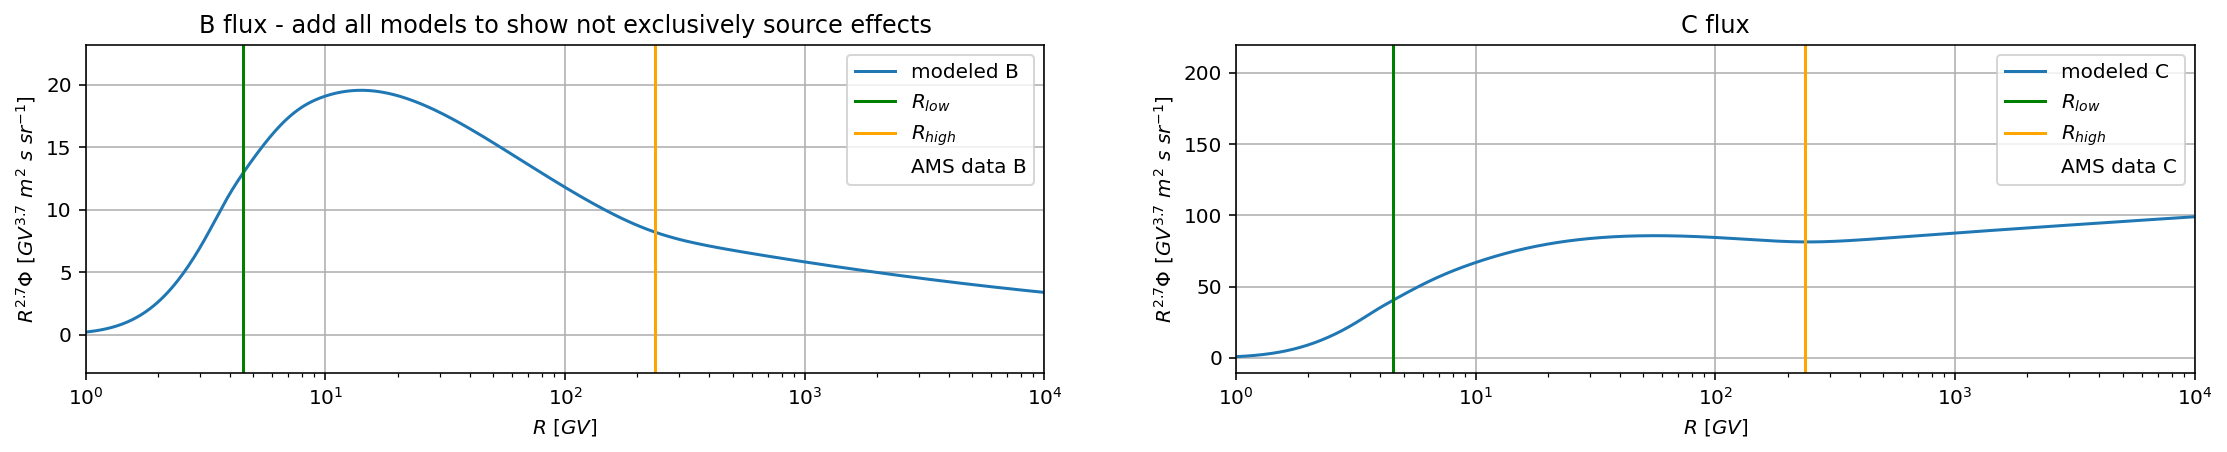

In [15]:
# Primary fraction plot

#       Boilerplate
fig = plt.figure(figsize=(twocolumn_width,0.5*column_width))
#plt.xlim(0.0009,1100000)
#plt.ylim(0,100)
fig.set_dpi(72*2)



# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
#ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
#ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.subplots_adjust(hspace=0.2)

#       Plotting
ax1 = fig.add_subplot(1,2,1)
#ax1_r = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(1,2,2)
#ax2_r = fig.add_subplot(2,2,4)
for i in (ax1, ax2):
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

#for i in (ax1_r, ax2_r):
#    i.set_xscale('log')
#    i.set_ylabel('Residual')
#    i.set_xlabel('$R\ [GV]$')
#    i.grid()

for i in (ax1, ax2):
    i.set_ylabel('$R^{2.7}\Phi\ [GV^{3.7}\ m^2\ s\ sr^{-1}]$')

ax3.set_ylabel('B/C')

for key in C_dat:
    if 'model_' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            if label == 'B':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) 
                #   Plot Graph
                # Model data
                y_model_scaled = np.array(C_dat[key.replace('fx','fy')])*np.array(C_dat[key])**2.7
                x_model = np.array(C_dat[key])
                ax1.plot(x_model, y_model_scaled, label='modeled '+label)

                # AMS data
                y_AMS_scaled            = np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'])*np.array(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])**2.7
                #                          ys_err = (2.7*xerr/x + yerr/y)*ys
                y_AMS_error_scaled      = [(2.7* ((data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT']+data['ERR_SYST'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled, (2.7* ((data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT+']+data['ERR_SYST+'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled]
                x_AMS                   = data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']
                x_AMS_error             = [data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']]

                ax1.errorbar(y=y_AMS_scaled, x=x_AMS, xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                ax1.set_title('B flux - add all models to show not exclusively source effects')
                # Plot residuals
                #ax1_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                #ax1_r.plot(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'],data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit)

            if label == 'C':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) 
                #   Plot Graph
                # Model data
                y_model_scaled = np.array(C_dat[key.replace('fx','fy')])*np.array(C_dat[key])**2.7
                x_model = np.array(C_dat[key])
                ax2.plot(x_model, y_model_scaled, label='modeled '+label)

                # AMS data
                y_AMS_scaled            = np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'])*np.array(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])**2.7
                #                          ys_err = (2.7*xerr/x + yerr/y)*ys
                y_AMS_error_scaled      = [(2.7* ((data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT']+data['ERR_SYST'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled, (2.7* ((data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT+']+data['ERR_SYST+'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled]
                x_AMS                   = data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']
                x_AMS_error             = [data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']]

                ax2.errorbar(y=y_AMS_scaled, x=x_AMS, xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                ax2.set_title('C flux')
                # Plot residuals
                #ax2_r.plot(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'],data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit)
                #ax2_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')



for i in (ax1, ax2):#,ax1_r, ax2_r
    i.axvline(transport_params['R_{low} (GV)'],label='$R_{low}$',c='green')
    i.axvline(transport_params['R_{break} (GV)'],label='$R_{high}$',c='orange')
for i in (ax1, ax2):
    i.legend()
    i.set_xlim(1,1e4)
#for i in ((ax1,ax1_r), (ax2,ax2_r)):
#    i[0].set_xlim(i[1].get_xlim())
#    i[1].set_ylim(-0.1,0.1)
#ax1_r.set_title('Residual plots absolutely meaningless in this context')
#ax2_r.set_title('Residual plots absolutely meaningless in this context')
#plt.savefig('/home/felix/USINE/gen_graphics/all_scaled_fluxes.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')
plt.show()


## Below is vals_out automatic table formating

This is to be done seperately

In [5]:
# Create Latex table of major parameters

import sys

model_paths = '/home/felix/USINE_docker/SLIM_data_pres'



model_val_files ={}
for i in os.listdir(model_paths):
    if 'out' in i:
        model_val_files['_'.join(i.split('_')[:-1:])]=os.path.join(model_paths,'model_vals_pars.out')

#Key latex fomatting dict for transport table
latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}


source_params = {}

# Extract Source parameters
for i in model_val_files:
    with open(model_val_files[i], 'r') as f:
        lines = f.readlines()
        cond = False
    for line in lines:
        if cond and line!='\n':
            key, value = line.split('=')
            # Add units
            key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
            if key.strip(' ') not in source_params.keys():   
                source_params[key.strip(' ')] = [float(value.split('[')[0].strip(' '))]
            else:
                source_params[key.strip(' ')].append(float(value.split('[')[0].strip(' ')))
        if '# Source' in line:
            cond = True

latexfile = 'tables.tex'


tableheader = '\\begin{tabular}{'+('c |'*(len(model_val_files)+1))[:-2:]+'}'

with open(latexfile, 'w') as f:
    # Preamble transport parameters
    f.write('Transport parameters:\n\n')
    f.write(tableheader+'\n')
    f.write('\tParameters & '+('{} &' *len(model_val_files)).format(*model_val_files.keys())[:-2:]+' \\\\ \n')
    f.write('\t\\cline\x7B1-'+str((len(model_val_files)+1))+'\x7D\n')
    # Actual Content
    for key in transport_params.keys():
        print(transport_params[key])
        f.write('\t$'+key+'$ & '+('${}$ &' *len(model_val_files)).format(transport_params[key])[:-2:]+' \\\\ \n')
    f.write('\end{tabular}\n\n')

    # Preamble Source parameters
    f.write('Source parameters:\n\n')
    f.write(tableheader+'\n')
    f.write('\tParameters & '+('{} &' *len(model_val_files)).format(*model_val_files.keys())[:-2:]+' \\\\ \n')
    f.write('\t\\cline\x7B1-'+str((len(model_val_files)+1))+'\x7D\n')
    # Actual Content
    for key in source_params.keys():
        # Format elemental notation
        if 'q_' in key:
            name, unit = [i for i in key.split(' ') if i]
            if name[2:4:].isnumeric():
                nucleon_nr = name[2:4:]
                elem = name[4::]
            elif name[2].isnumeric():
                nucleon_nr = name[2]
                elem= name[3::]
            else:
                print(name)
            if len(elem) > 1:
                elem = elem[0].upper() + elem[1::].lower()
            name='q_\x7B^\x7B'+nucleon_nr+'\x7D'+elem+'\x7D '+unit
        # Format elemental notation and alpha
        if 'alpha' in key:
            quant, name = [i for i in key.split(' ')[0].split('_') if i]
            if name[0:2:].isnumeric():
                nucleon_nr = name[0:2:]
                elem = name[2::]
            elif name[0].isnumeric():
                nucleon_nr = name[0]
                elem= name[1::]
            else:
                print(name)
                nucleon_nr = ''
                elem = name
            if len(elem) > 1:
                elem = elem[0].upper() + elem[1::].lower()
            name = '\\alpha_\x7B^\x7B'+nucleon_nr+'\x7D'+elem+'\x7D'
        if 'eta' in key:
            name = '\\'+key
        f.write('\t$'+name+'$ & '+('${}$ &' *len(model_val_files)).format(*source_params[key])[:-2:]+' \\\\ \n')
    f.write('\end{tabular}\n\n')


7.0


IndexError: Replacement index 1 out of range for positional args tuple

## Diff coeff - Done

In [6]:
#def calculate_diff_coeff(Rigidity, transport_params):
#    """
#    Calculate the diffusion coefficient as a function of rigidity
#    Rigidity - list of rigidity values
#    model_val_files_dict - dictionary of model values from model_vals_pars.out loaded as below
#    """
#    for key in transport_params:
#        if type(transport_params[key]) == list:
#            transport_params[key] = transport_params[key][0]
#    ratio = (938.28+939.57)*1e-3
#    # Relativistic velocity
#    beta = Rigidity/np.sqrt(Rigidity**2+ratio**2)
#    # Calculate the diffusion coefficient
#    nonR_R = transport_params['K_0 (kpc^2/Myr)']*np.power(beta, transport_params['\\eta_t (-)'])
#    low_R = np.power(1+np.power(Rigidity/transport_params['R_{low} (GV)'], (transport_params['\\delta_{low} (-)']-transport_params['\\delta (-)'])/transport_params['s_{low} (-)']),transport_params['s_{low} (-)'])
#    intermid_R = np.power(Rigidity/10, transport_params['\\delta (-)'])
#    high_R = np.power(1+np.power(Rigidity/transport_params['R_{break} (GV)'], (transport_params['\\delta (-)']-transport_params['\\delta_{break} (-)'])/transport_params['s_{break} (-)']),-transport_params['s_{break} (-)'])
#    K = nonR_R*low_R*intermid_R*high_R
#    return K

# Second implementation cause mine doesnt work

def calculate_diff_coeff(Rigidity, transport_params):
    """
    Calculate the diffusion coefficient as a function of rigidity
    Rigidity - list of rigidity values
    model_val_files_dict - dictionary of model values from model_vals_pars.out loaded as below
    """
    for key in transport_params:
        if type(transport_params[key]) == list:
            transport_params[key] = transport_params[key][0]
    ratio = (938.28+939.57)*1e-3
    # Relativistic velocity
    beta = Rigidity/np.sqrt(Rigidity**2+ratio**2)
    # Calculate the diffusion coefficient
    nonR_R = transport_params['K_0 (kpc^2/Myr)']*np.power(beta, transport_params['\\eta_t (-)'])
    low_R = np.power(1+np.power(Rigidity/transport_params['R_{low} (GV)'], (transport_params['\\delta_{low} (-)']-transport_params['\\delta (-)'])/transport_params['s_{low} (-)']),transport_params['s_{low} (-)'])
    intermid_R = np.power(Rigidity, transport_params['\\delta (-)'])
    high_R = np.power(1+np.power(Rigidity/transport_params['R_{break} (GV)'], (transport_params['\\delta_{break} (-)'])/transport_params['s_{break} (-)']),-transport_params['s_{break} (-)'])
    K = nonR_R*low_R*intermid_R*high_R
    return K


No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


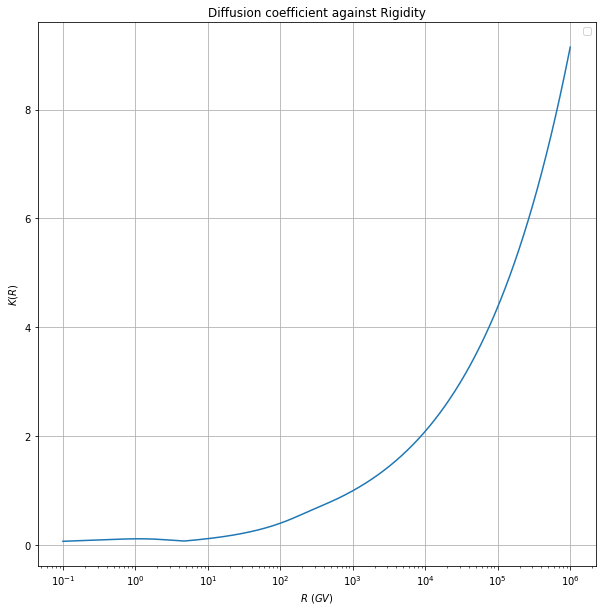

In [7]:
# Get data for all models
model_paths = '/home/felix/USINE_docker/'

model_val_files ={}
for i in os.listdir(model_paths):
    if 'out' in i:
        model_val_files['_'.join(i.split('_')[:-1:])]=os.path.join(model_paths, i,'model_vals_pars.out')


R = np.logspace(-1,6,1000)
K = calculate_diff_coeff(R, transport_params)

fig = plt.figure(figsize=(10,10))

plt.xscale('log')

plt.ylabel(r'$K(R)$')
plt.xlabel(r'$R\ (GV)$')
plt.title(r'Diffusion coefficient against Rigidity') 

plt.plot(R,K)

plt.grid()
plt.legend()

plt.savefig('/home/felix/USINE_docker/gen_graphics/diff_coeff_vs_rigidity.png',bbox_inches='tight')

### Here we will calculate the flux slopes 

In [10]:
def get_loglog_slope(fx, fy):
    '''fx and fy as returned by model
    returns log slopes
    '''
    logx = np.log10(fx)
    logy = np.log10(fy)
    grad = (logy[1::]-logy[:-1:])/(logx[1::]-logx[:-1:])
    return grad

In [11]:
R = np.logspace(-1, 6,1000)
K = calculate_diff_coeff(R, transport_params)
K_grad = get_loglog_slope(R, K)

## CMD construction and verification all is done

In [2]:
# For the following we model all the fluxes for which we have data and compute their gradients those are
data_present = ['B/O', 'Be/C', 'Li/O', 'Li/C', 'F/Si', 'Be/O', 'C', 'He/O', 'Ne', 'C/O', 'He', 'Be/B', 'Si/O', 'N', 'O', 'Ne/O', 'Si', 'B', 'Li/B', 'H', 'Mg/O', 'Mg', 'B/C', 'Li'] #, '1HBAR'

# USINE issue maybe order related
data_present = [i for i in data_present if '/' not in i]+[i for i in data_present if '/' in i]

element_dict = {'H':1,'He':2, 'Li':3, 'Be':4,'B':5,'C':6,'N':7,'O':8,'F':9,'Ne':10,'Na':11,'Mg':12,'Al':13,'Si':14,'P':15,'S':16,'Cl':17,'Ar':18,'K':19,'Ca':20,'Sc':21,'Ti':22,'V':23,'Cr':24,'Mn':25,'Fe':26}

# ALso need all non fractions

not_in_prev = []
for key in element_dict:
    if key not in data_present:
        not_in_prev.append(key)

data_present = not_in_prev+data_present

cmd_to_run = './USINE/bin/usine -l ~/usine_models/init.SLIM.par ~/USINE_out_57 "{}:kR:0.57"  0  1  1  1'.format(','.join(element_dict.keys()))
print(cmd_to_run)

./USINE/bin/usine -l ~/usine_models/init.SLIM.par ~/USINE_out_57 "H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe:kR:0.57"  0  1  1  1


In [13]:
# Verify files
if len([i for i in os.listdir(model_dir) if 'local_fl' in i and i[-2::]=='.C' and 'primary' not in i and 'isotop' not in i]) == len(data_present): print('All Files present: {} files'.format(len(data_present)))
else: print(-len([i for i in os.listdir(model_dir) if 'local_fl' in i and i[-2::]=='.C' and 'primary' not in i and 'isotop' not in i])+len(data_present), ' Files missing')

All Files present: 24 files


## AMS data slopes

In [14]:
AMS_slopes = {}

for key in AMS_data.keys():
    if key!='FSIREF.dat':
        try:
            try: # The column header is for O and Li with a full stop for some reason
                R = AMS_data[key]['<E>: mean value bin [GeV/n, GeV, GV, or GeV]'].to_numpy()
            except:
                R = AMS_data[key]['<E>: mean value bin [GeV/n. GeV. GV. or GeV]'].to_numpy()
            try:
                flux = AMS_data[key]['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'].to_numpy()
            except:
                flux = AMS_data[key]['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux . no unit if ratio'].to_numpy()
            AMS_slopes[key] = [R[1::], get_loglog_slope(R, flux)]
        except Exception as e:
            print(key)
            print(e)

## SLIM 670 MV compute flux slope

In [15]:
SLIM_slopes = {}
for key in C_dat.keys():
    if 'fx' not in key and 'model' in key:
        SLIM_slopes[key.split('_')[1]] = [C_dat[key.replace('fy','fx')][1::], get_loglog_slope(C_dat[key.replace('fy','fx')],C_dat[key])]

## Plot flux slopes for each species


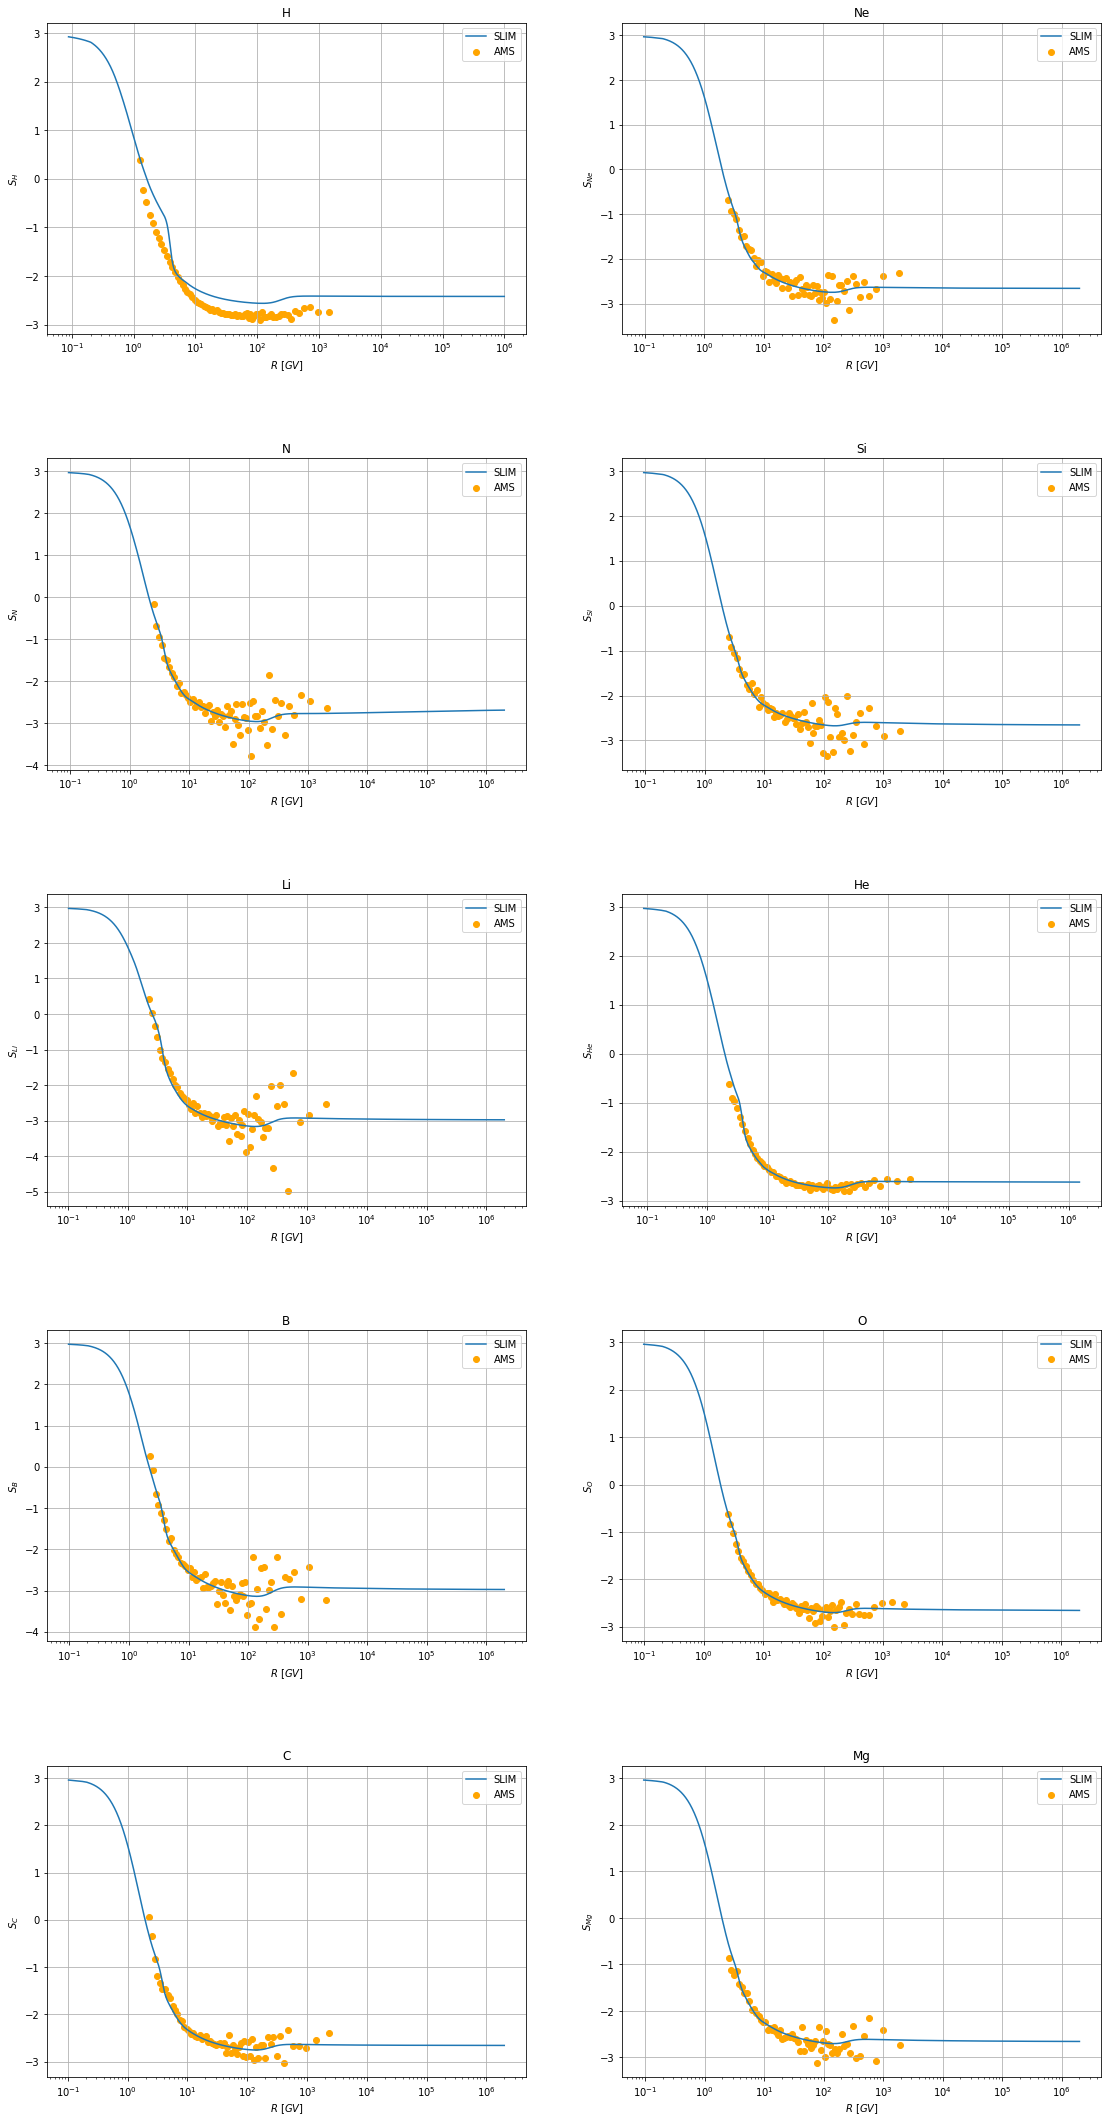

In [16]:
fig, ax = plt.subplots(5,2,figsize=(twocolumn_width,2*twocolumn_width))
#fig.set_dpi(72*2)

# To avoid overwriting the original instance
axes = ax.flatten()
plt.subplots_adjust(hspace=0.4)

for i in axes:
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

name_dict = {'BO': 'B/O', 'BeC': 'Be/C', 'LiO': 'Li/O', 'LiC': 'Li/C', 'FSi': 'F/Si', 'BeO': 'Be/O', 'C': 'C', 'HeO': 'He/O', '1HBAR': '1HBAR', 'Ne': 'Ne', 'CO': 'C/O', 'He': 'He', 'BeB': 'Be/B', 'SiO': 'Si/O', 'N': 'N', 'O': 'O', 'NeO': 'Ne/O', 'Si': 'Si', 'B': 'B', 'LiB': 'Li/B', 'H': 'H', 'MgO': 'Mg/O', 'Mg': 'Mg', 'BC': 'B/C', 'Li': 'Li'}
ams_name_dict = {'BEC':'BeC','BO':'BO','C': 'C','LIO':'LiO', 'LIC':'LiC', 'FSI':'FSi', 'BEO':'BeO', 'HEO':'HeO', '1HBAR':'1HBAR', 'NE':'Ne', 'CO':'CO', 'HE':'He', 'BEB':'BeB', 'SIO':'SiO', 'N':'N', 'O':'O', 'NEO':'NeO', 'SI':'Si', 'B':'B', 'LIB':'LiB', 'H':'H', 'MGO':'MgO', 'MG':'Mg', 'BC':'BC', 'LI':'Li'}

ax_counter = 0
for key in SLIM_slopes:
    # Get correct casing for AMS indexing
    ams_name = ams_name_dict[key]
    # Add fraction / where required
    name = name_dict[ams_name]

    if '/' not in name: 

        axes[ax_counter].set_ylabel(r'$S_'+'\x7B'+'{}'.format(name)+'\x7D$')
    
        axes[ax_counter].plot(*SLIM_slopes[key], label='SLIM')

        axes[ax_counter].scatter(*AMS_slopes[ams_name],c='orange', label='AMS')
    
        axes[ax_counter].legend()
    
        axes[ax_counter].set_title(name)
    
        #axes[ax_counter].set_ylim(-5,5)
    
        ax_counter+=1
    

Text(0.5, 1.0, 'SLIM vs AMS log log fluxes')

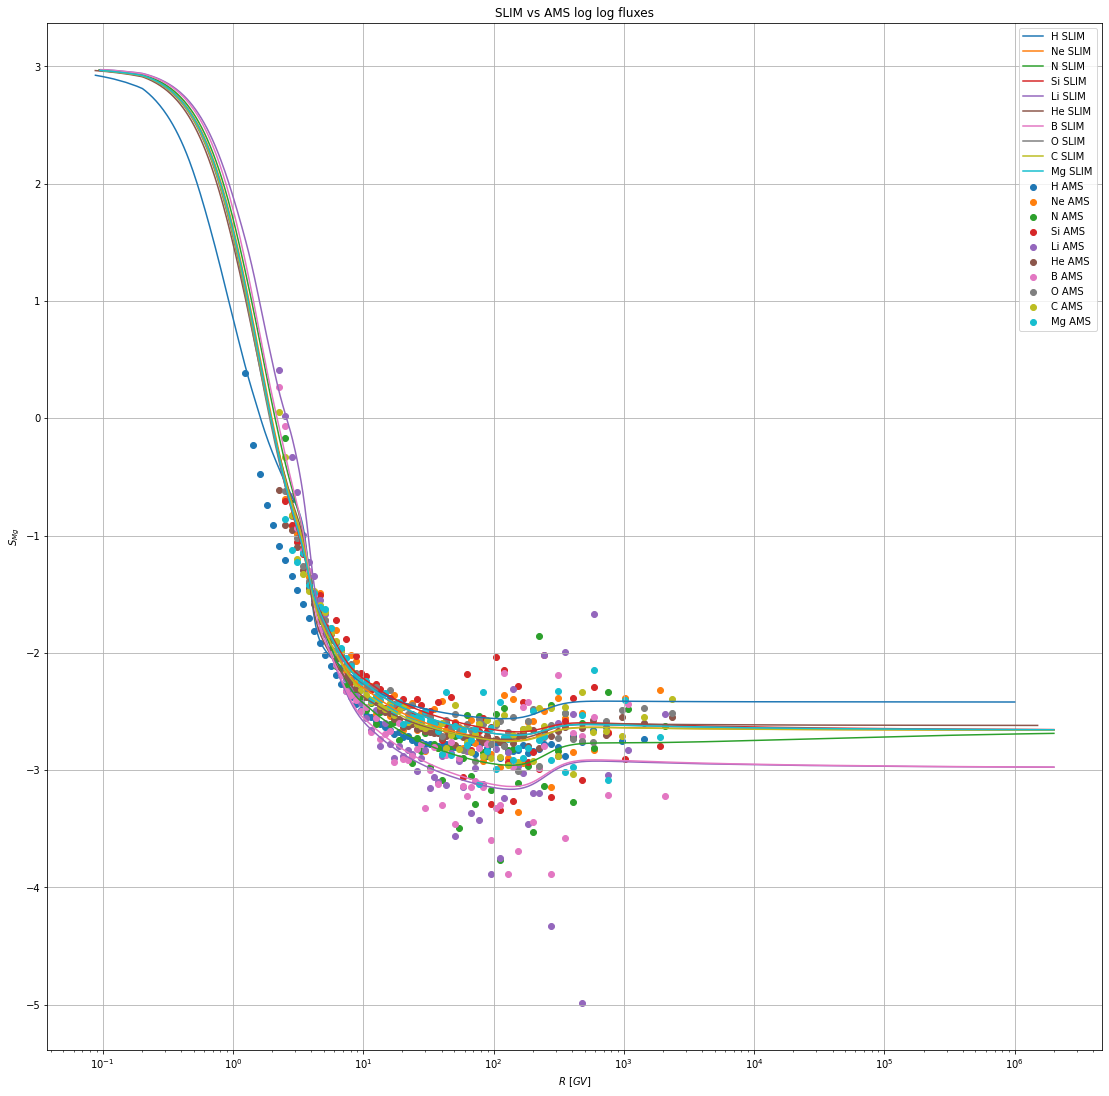

In [17]:
# log log slope one plot
fig, ax = plt.subplots(1,1,figsize=(twocolumn_width,twocolumn_width))
#fig.set_dpi(72*2)

# To avoid overwriting the original instance
axes = ax
plt.subplots_adjust(hspace=0.4)

axes.set_xscale('log')
axes.set_xlabel('$R\ [GV]$')
axes.grid()

name_dict = {'BO': 'B/O', 'BeC': 'Be/C', 'LiO': 'Li/O', 'LiC': 'Li/C', 'FSi': 'F/Si', 'BeO': 'Be/O', 'C': 'C', 'HeO': 'He/O', '1HBAR': '1HBAR', 'Ne': 'Ne', 'CO': 'C/O', 'He': 'He', 'BeB': 'Be/B', 'SiO': 'Si/O', 'N': 'N', 'O': 'O', 'NeO': 'Ne/O', 'Si': 'Si', 'B': 'B', 'LiB': 'Li/B', 'H': 'H', 'MgO': 'Mg/O', 'Mg': 'Mg', 'BC': 'B/C', 'Li': 'Li'}
ams_name_dict = {'BEC':'BeC','BO':'BO','C': 'C','LIO':'LiO', 'LIC':'LiC', 'FSI':'FSi', 'BEO':'BeO', 'HEO':'HeO', '1HBAR':'1HBAR', 'NE':'Ne', 'CO':'CO', 'HE':'He', 'BEB':'BeB', 'SIO':'SiO', 'N':'N', 'O':'O', 'NEO':'NeO', 'SI':'Si', 'B':'B', 'LIB':'LiB', 'H':'H', 'MGO':'MgO', 'MG':'Mg', 'BC':'BC', 'LI':'Li'}

for key in SLIM_slopes:
    # Get correct casing for AMS indexing
    ams_name = ams_name_dict[key]
    # Add fraction / where required
    name = name_dict[ams_name]

    if '/' not in name: 

        axes.set_ylabel(r'$S_'+'\x7B'+'{}'.format(name)+'\x7D$')
    
        axes.plot(*SLIM_slopes[key], label=name+' SLIM')

        axes.scatter(*AMS_slopes[ams_name], label=name+' AMS')
    
        axes.legend()
    
axes.set_title('SLIM vs AMS log log fluxes')
    

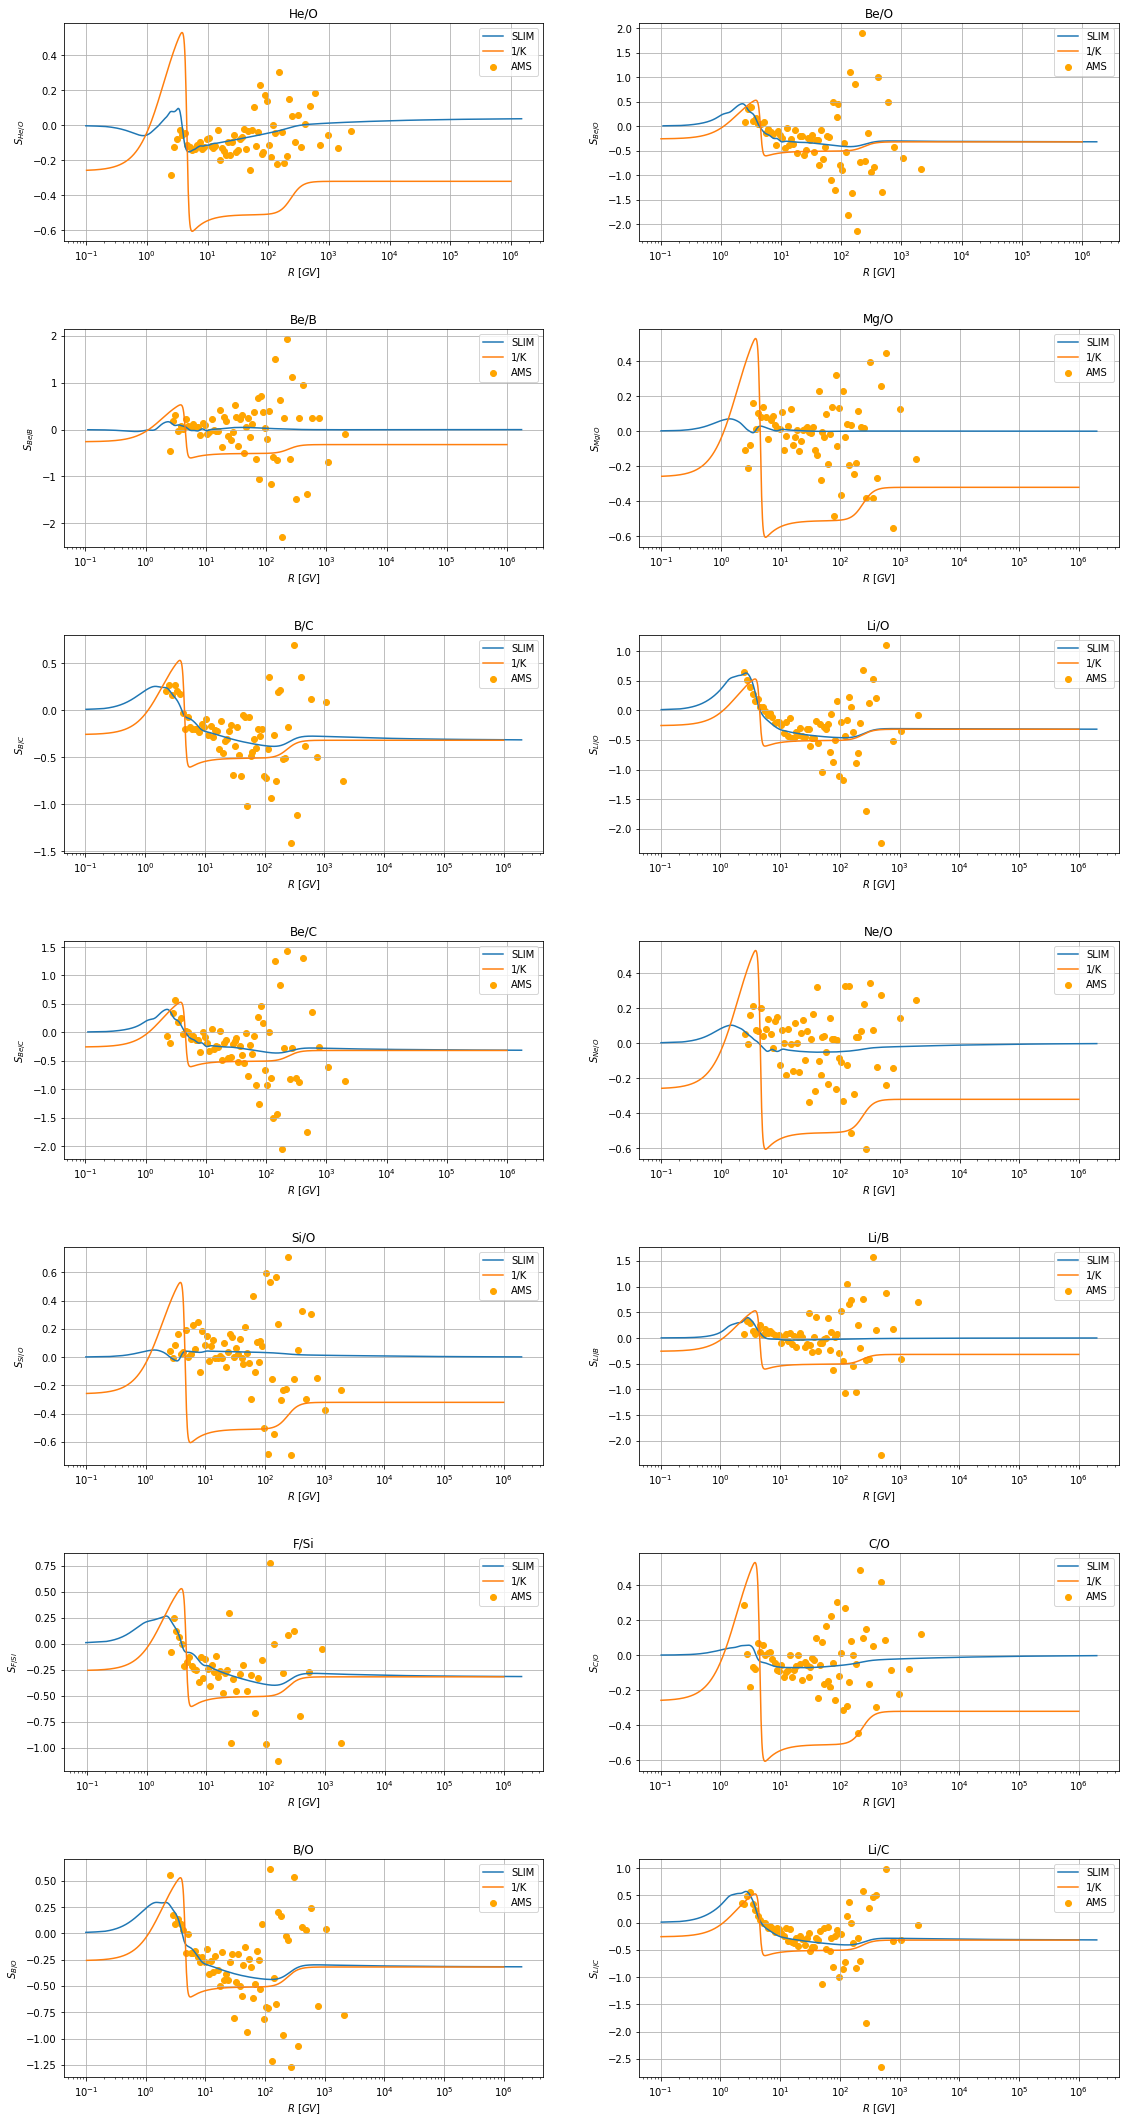

In [48]:
fig, ax = plt.subplots(7,2,figsize=(twocolumn_width,2*twocolumn_width))
#fig.set_dpi(72*2)

# To avoid overwriting the original instance
axes = ax.flatten()
plt.subplots_adjust(hspace=0.4)

for i in axes:
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

name_dict = {'BO': 'B/O', 'BeC': 'Be/C', 'LiO': 'Li/O', 'LiC': 'Li/C', 'FSi': 'F/Si', 'BeO': 'Be/O', 'C': 'C', 'HeO': 'He/O', '1HBAR': '1HBAR', 'Ne': 'Ne', 'CO': 'C/O', 'He': 'He', 'BeB': 'Be/B', 'SiO': 'Si/O', 'N': 'N', 'O': 'O', 'NeO': 'Ne/O', 'Si': 'Si', 'B': 'B', 'LiB': 'Li/B', 'H': 'H', 'MgO': 'Mg/O', 'Mg': 'Mg', 'BC': 'B/C', 'Li': 'Li'}
ams_name_dict = {'BEC':'BeC','BO':'BO','C': 'C','LIO':'LiO', 'LIC':'LiC', 'FSI':'FSi', 'BEO':'BeO', 'HEO':'HeO', '1HBAR':'1HBAR', 'NE':'Ne', 'CO':'CO', 'HE':'He', 'BEB':'BeB', 'SIO':'SiO', 'N':'N', 'O':'O', 'NEO':'NeO', 'SI':'Si', 'B':'B', 'LIB':'LiB', 'H':'H', 'MGO':'MgO', 'MG':'Mg', 'BC':'BC', 'LI':'Li'}

ax_counter = 0
for key in SLIM_slopes:
    # Get correct casing for AMS indexing
    ams_name = ams_name_dict[key]
    # Add fraction / where required
    name = name_dict[ams_name]

    if '/' in name: 

        axes[ax_counter].set_ylabel(r'$S_'+'\x7B'+'{}'.format(name)+'\x7D$')
    
        axes[ax_counter].plot(*SLIM_slopes[key], label='SLIM')

        axes[ax_counter].plot(np.logspace(-1,6,1000)[1::], -K_grad, label='1/K')

        axes[ax_counter].scatter(*AMS_slopes[ams_name],c='orange', label='AMS')
    
        axes[ax_counter].legend()
    
        axes[ax_counter].set_title(name)
    
        #axes[ax_counter].set_ylim(-5,5)
    
        ax_counter+=1
    

In [1]:
# Replicate fig 4

# Generate 3 more values of fitz

# Make plot with 20 and 200 GV

# Make AMS gradient better



In [100]:
# First we interpolate all data points for 20 and 200 GV, dont need AMS data to be provided

flux_20 = {}
flux_200 = {}

name_dict = {'BO': 'B/O', 'BeC': 'Be/C', 'LiO': 'Li/O', 'LiC': 'Li/C', 'FSi': 'F/Si', 'BeO': 'Be/O', 'C': 'C', 'HeO': 'He/O', '1HBAR': '1HBAR', 'Ne': 'Ne', 'CO': 'C/O', 'He': 'He', 'BeB': 'Be/B', 'SiO': 'Si/O', 'N': 'N', 'O': 'O', 'NeO': 'Ne/O', 'Si': 'Si', 'B': 'B', 'LiB': 'Li/B', 'H': 'H', 'MgO': 'Mg/O', 'Mg': 'Mg', 'BC': 'B/C', 'Li': 'Li'}
ams_name_dict = {'BEC':'BeC','BO':'BO','C': 'C','LIO':'LiO', 'LIC':'LiC', 'FSI':'FSi', 'BEO':'BeO', 'HEO':'HeO', '1HBAR':'1HBAR', 'NE':'Ne', 'CO':'CO', 'HE':'He', 'BEB':'BeB', 'SIO':'SiO', 'N':'N', 'O':'O', 'NEO':'NeO', 'SI':'Si', 'B':'B', 'LIB':'LiB', 'H':'H', 'MGO':'MgO', 'MG':'Mg', 'BC':'BC', 'LI':'Li'}


for key in SLIM_slopes:
    interpolator = interp1d(SLIM_slopes[key][0],SLIM_slopes[key][1],kind='cubic')
    flux_20[ams_name_dict[key]] = interpolator(20)
    flux_200[ams_name_dict[key]] = interpolator(200)


# Construct dict with element:proton number until Fe
element_dict = {'H':1,'He':2, 'Li':3, 'Be':4,'B':5,'C':6,'N':7,'O':8,'F':9,'Ne':10,'Na':11,'Mg':12,'Al':13,'Si':14,'P':15,'S':16,'Cl':17,'Ar':18,'K':19,'Ca':20,'Sc':21,'Ti':22,'V':23,'Cr':24,'Mn':25,'Fe':26}

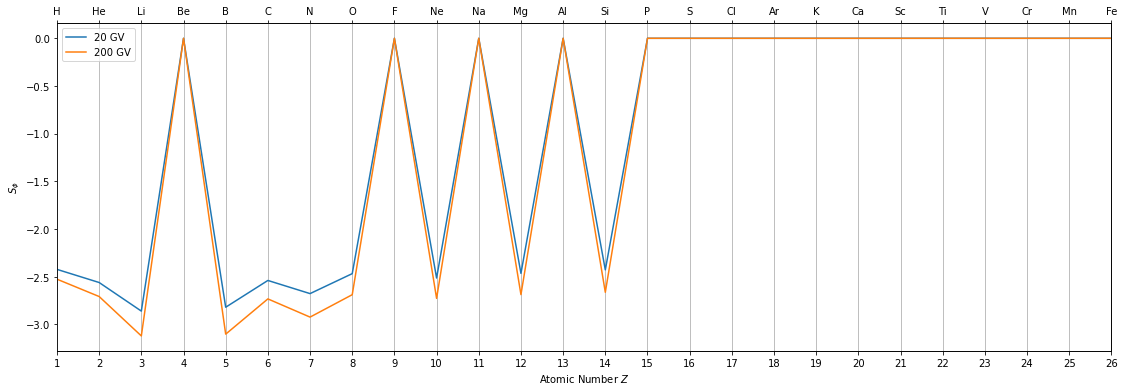

In [104]:
fig,ax = plt.subplots(1,1,figsize=(twocolumn_width,column_width))

ax.set_ylabel('$S_\x7B \phi \x7D$')
ax.set_xlabel('Atomic Number $Z$')

ax.set_xticks(np.arange(0,27,1))
#ax.set_xticklabels(np.arange(0,27,1))
ax.set_xlim(1,26)

x2 = ax.twiny()

x2.set_xticks(np.arange(0,27,1))
#x2.set_xticks([i for i in element_dict.values()])
x2.set_xticklabels(['']+[i for i in element_dict])

flux20 = np.zeros(len(element_dict))
flux200 = np.zeros(len(element_dict))

for key in flux_20:
    if key in element_dict:
        flux20[element_dict[key]-1] = flux_20[key]
        flux200[element_dict[key]-1] = flux_200[key]

plt.plot(np.arange(1,27,1),flux20,label='20 GV')
plt.plot(np.arange(1,27,1),flux200,label='200 GV')
plt.xlim(1,26)
plt.grid()
plt.legend()

FSi  doesnt have headers
FSIREF.dat  doesnt have headers
FSi  doesnt have headers
FSIREF.dat  doesnt have headers
FSi  doesnt have headers
FSIREF.dat  doesnt have headers


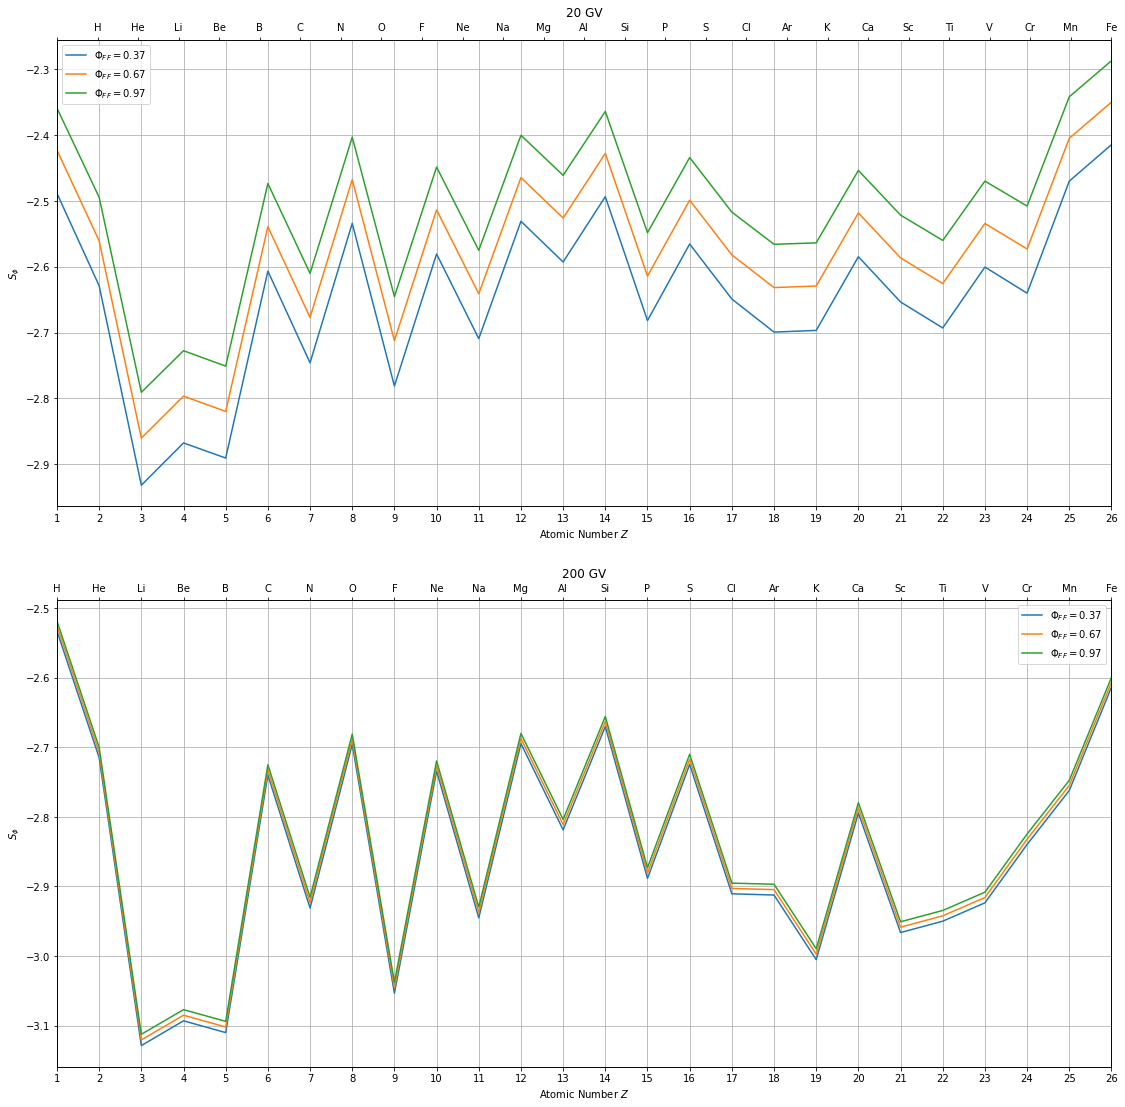

In [12]:
import matplotlib.pyplot as plt
from autogen import *

# Make All data Z plots

model_dirs = 'USINE_out_'
model_dirs = [model_dirs+i for i in ('37','67','97')]

fig,ax = plt.subplots(2,1,figsize=(twocolumn_width,twocolumn_width))

ax[0].set_title('20 GV')
ax[1].set_title('200 GV')

for i in ax:
    i.set_ylabel('$S_\x7B \phi \x7D$')
    i.set_xlabel('Atomic Number $Z$')
    i.set_xticks(np.arange(0,27,1))
    i.set_xlim(1,26)
    i.grid()

    x2 = i.twiny()

    x2.set_xticks(np.arange(0,27,1))
    #x2.set_xticks([i for i in element_dict.values()])
    x2.set_xticklabels(['']+[i for i in element_dict])


for model_dir in model_dirs:
    transport_params, source_params, AMS_data, C_dat = get_transport_and_source(model_dir)

    SLIM_slopes = get_model_slopes(C_dat)

    flux_20 = {}
    flux_200 = {}

    for key in SLIM_slopes:
        interpolator = interp1d(SLIM_slopes[key][0],SLIM_slopes[key][1],kind='cubic')
        flux_20[ams_name_dict[key]] = interpolator(20)
        flux_200[ams_name_dict[key]] = interpolator(200)
      

    flux20 = np.zeros(len(element_dict))
    flux200 = np.zeros(len(element_dict))

    for key in flux_20:
        if key in element_dict:
            flux20[element_dict[key]-1] = flux_20[key]
            flux200[element_dict[key]-1] = flux_200[key]

    ax[0].plot(np.arange(1,27,1),flux20,label=r'$\Phi_{FF}=0.'+model_dir.split('_')[-1]+'$')
    ax[1].plot(np.arange(1,27,1),flux200,label=r'$\Phi_{FF}=0.'+model_dir.split('_')[-1]+'$')


plt.xlim(1,26)
ax[0].legend()
ax[1].legend()

plt.savefig('/home/felix/USINE_docker/'+model_dir+'/plots/Zslope_all.png',bbox_inches='tight')

